In [1]:
import skimage as sk
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from skimage import io, feature, filters, color, restoration, util
from skimage.morphology import watershed
from skimage.future import graph
from skimage.filters import threshold_otsu, threshold_local
from scipy import ndimage as ndi

In [2]:
exec(open('/Users/kpuhger/Documents/count-cellula/src/heq.py').read())
exec(open('/Users/kpuhger/Documents/count-cellula/src/smoothing.py').read())

In [3]:
# load image
img_file = '/Users/kpuhger/Box Sync/count_cellula_imgs/SampleGFP.tif'
img = sk.io.imread(img_file)

next, we'll use adaptive equalization to enhance the image

In [4]:
# step 1 gaussian blur image
img_gauss = gaussian_blur(img, 3)

# step 2 perform adaptive equalization on blurred image
img_gauss_aeq = adapt_eq(img_gauss)

/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


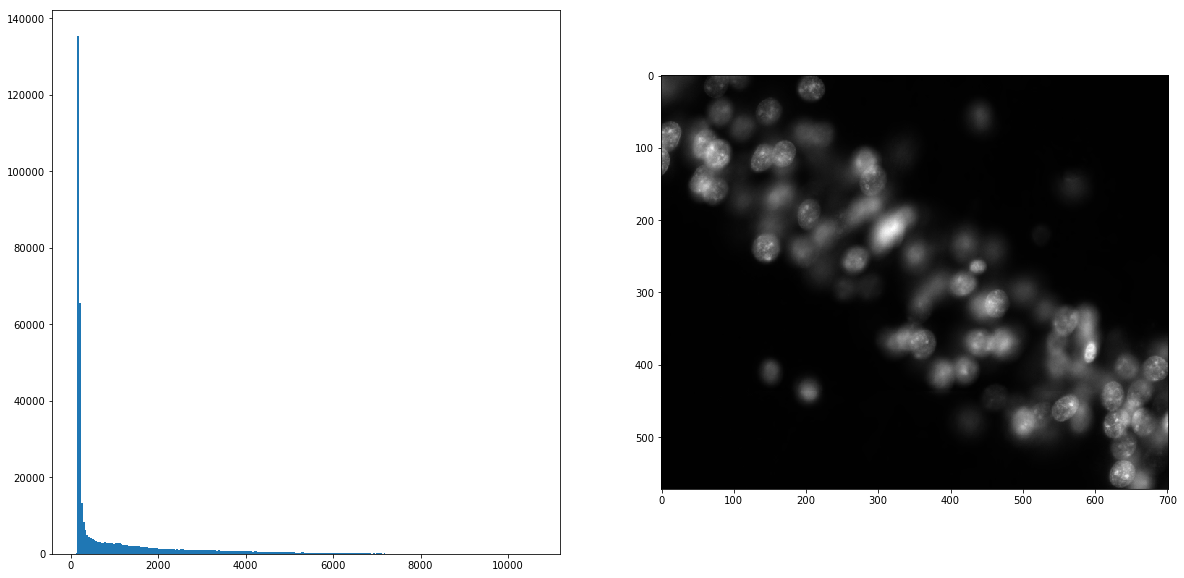

In [5]:
img_hist_stack(img, 9)

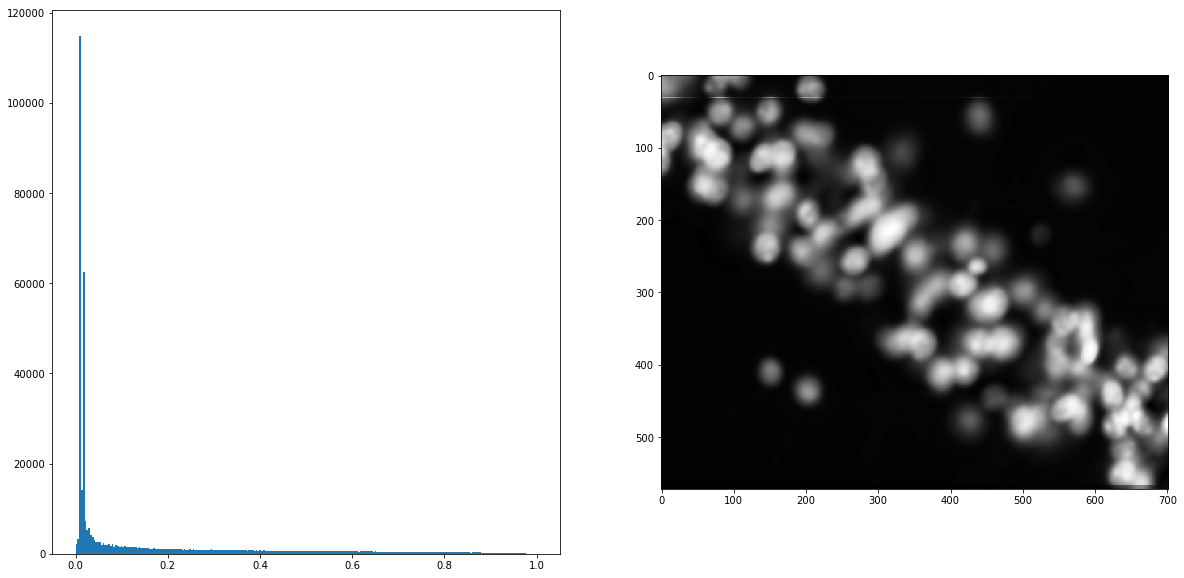

In [6]:
# test image
img_hist_stack(img_gauss_aeq, 9)

In [7]:
img_gauss_aeq_lmax = ndi.maximum_filter(img_gauss_aeq, size = 5)

# test image
#img_hist_stack(seeds_local_max, 9)

## Edge detection

In [8]:
# edges1 = filters.sobel(img_gauss_aeq[9, :, :])
# edges2 = filters.sobel(img_gauss[9, :, :])
# edges3 = filters.sobel(img[9, :, :])

# # f, ax = plt.subplots(ncols=3, figsize=(20,20))
# # ax[0].imshow(edges1, cmap='gray')
# # ax[0].set_axis_off();
# # ax[1].imshow(edges2, cmap='gray')
# # ax[1].set_axis_off();
# # ax[2].imshow(edges3, cmap='gray')
# # ax[2].set_axis_off();

In [9]:
# # distance transform of thresholded edges
# threshold = filters.threshold_otsu(edges2)
# non_edges = (edges2 < threshold)
# plt.imshow(non_edges)


In [32]:
# get edges and peaks and perform watershed segmentation
def edges_stack(img, **kwargs):
    # get edges
    edges = np.empty_like(img)
    for z in range(len(img)):
        edges[z] = filters.sobel(img[z])
    return edges

    # get peaks

def peak_stack(img, **kwargs):
    edges = edges_stack(img)
    threshold = np.empty_like(img)
    peaks = np.zeros((2, 3))
    non_edges = np.empty_like(img)
    distance_from_edge = np.empty_like(img)
    peaks_image = np.empty_like(img)
    seeds = non_edges = np.empty_like(img)
    for z in range(len(img)):
        threshold[z, :, :] = filters.threshold_otsu(edges[z, :, :])
        non_edges[z, :, :] = (edges[z, :, :] < threshold[z, :, :])
        distance_from_edge[z, :, :] = ndi.distance_transform_edt(non_edges[z, :, :])
        peaks[z, :, :] = feature.peak_local_max(distance_from_edge[z, :, :], min_distance=9)
        peaks_image[z, :, :] = np.zeros(img[z, :, :].shape, np.bool)
        peaks_image[z, :, :][tuple(np.transpose(peaks[z, :, :]))] = True
        seeds[z, :, :], num_seeds = ndi.label(peaks_image[z, :, :])
    
    return peaks, seeds, peaks_image, distance_from_edge, non_edges

# watershed
def ws_stack(img, **kwargs):
    ws = np.empty_like(img)
    for z in range(len(img)):
        ws[z, :, :] = watershed(edges[z, :, :], seeds[z, :, :])
    return ws


In [33]:
# examining segmentation
def weight_boundary(graph, src, dst, n):
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']
    
    count = count_src + count_dst
    weighted_mean = (count_src * weight_src +
                     count_dst * weight_dst) / count

    return {'count': count, 'weight': weighted_mean}


def do_nothing(*args, **kwargs):
    pass


def ws_graph(img):
    rag_graph = np.empty_like(img)
    seg_cells = np.empty_like(img)
    for z in range(len(img)):
        rag_graph[z, :, :] = graph.rag_boundary(ws[z, :, :], edges[z, :, :])
        seg_cells[z, :, :] = graph.merge_hierarchical(ws[z, :, :], rag_graph[z, :, :], 
                                                thresh=0.013, rag_copy=True, 
                                                in_place_merge=True, merge_func=do_nothing,
                                     weight_func=weight_boundary)
    return rag_graph
    return seg_cells

def plot_ws_results(ws_img, z):        
    fig, ax = plt.subplots(ncols=3, figsize=(20,20))
    ax[0].imshow(ws_img[z, :, :], cmap='gray')
    ax[0].set_axis_off();
    ax[1].imshow(ws_img[z, :, :], cmap='gray')
    ax[1].plot(peaks[:, 1], peaks[:, 0], 'ro');
    ax[1].set_axis_off();
    ax[2].imshow(segmentation.mark_boundaries(ws_img[z, :, :], seg_cells))
    ax[2].set_axis_off();

In [34]:
peak_stack(img_gauss)

IndexError: too many indices for array

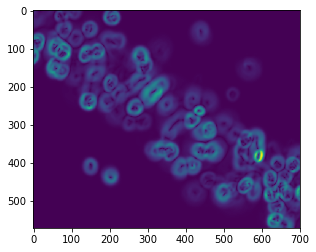

In [166]:
gauss_edges = edges_peaks(img_gauss)

plt.imshow(gauss_edges[9, :, :])

In [159]:
distance_from_edge = ndi.distance_transform_edt(non_edges)
peaks = feature.peak_local_max(distance_from_edge, min_distance=9)
print("Peaks shape:", peaks.shape)

# plt.imshow(distance_from_edge, cmap='gray');

Peaks shape: (215, 2)


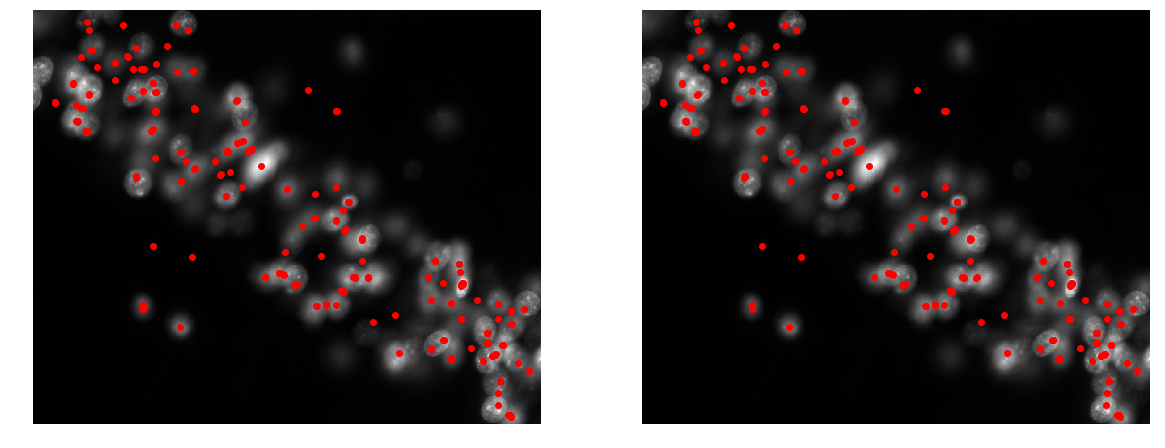

In [110]:
peaks_image = np.zeros(img_gauss[9, :, :].shape, np.bool)
peaks_image[tuple(np.transpose(peaks))] = True
seeds, num_seeds = ndi.label(peaks_image)


fig, ax = plt.subplots(ncols=2, figsize=(20,20))
ax[0].imshow(img[9, :, :], cmap='gray')
ax[0].plot(peaks[:, 1], peaks[:, 0], 'ro');
ax[0].set_axis_off();
ax[1].imshow(img[9, :, :], cmap='gray')
ax[1].plot(peaks[:, 1], peaks[:, 0], 'ro');
ax[1].set_axis_off();

In [111]:
# watershed

ws_edge = watershed(edges2, seeds)

In [112]:
def weight_boundary(graph, src, dst, n):
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']
    
    count = count_src + count_dst
    weighted_mean = (count_src * weight_src +
                     count_dst * weight_dst) / count

    return {'count': count, 'weight': weighted_mean}


def do_nothing(*args, **kwargs):
    pass

In [145]:
#
rag_graph = graph.rag_boundary(ws_edge, edges2)
seg_cells = graph.merge_hierarchical(ws_edge, rag_graph, thresh=0.013, rag_copy=True,
                                     in_place_merge=True,
                                     merge_func=do_nothing,
                                     weight_func=weight_boundary)

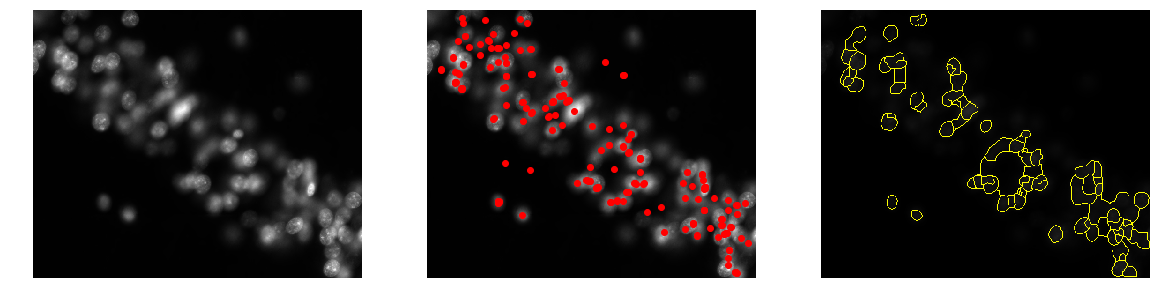

In [146]:
from skimage import segmentation

rag_graph = graph.rag_boundary(ws_edge, edges2)
seg_cells = graph.merge_hierarchical(ws_edge, rag_graph, thresh=0.013, rag_copy=True,
                                     in_place_merge=True,
                                     merge_func=do_nothing,
                                     weight_func=weight_boundary)


fig, ax = plt.subplots(ncols=3, figsize=(20,20))
ax[0].imshow(img[9, :, :], cmap='gray')
ax[0].set_axis_off();
ax[1].imshow(img[9, :, :], cmap='gray')
ax[1].plot(peaks[:, 1], peaks[:, 0], 'ro');
ax[1].set_axis_off();
ax[2].imshow(segmentation.mark_boundaries(img[9, :,:], seg_cells))
ax[2].set_axis_off();

### threshold-based watershed -- incomplete, currently abandoned

In [7]:
markers1 = rank.gradient(img_guass_aeq_lmax[9, :, :], disk(5)) < 10
markers1 = ndi.label(markers1)[0]

gradient1 = rank.gradient(img_guass_aeq_lmax[9, :, :], disk(2))

/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [8]:
markers2 = np.empty_like(img_gauss_aeq)
for z in range(len(img_guass_aeq_lmax)):
    markers2[z, :, :] = rank.gradient(img_guass_aeq_lmax[z, :, :], disk(5)) < 10
    markers2[z, :, :] = ndi.label(markers2[z, :, :])[0]
    
gradient2 = np.empty_like(img_gauss_aeq)
for z in range(len(img_guass_aeq_lmax)):
    gradient2[z, :, :] = rank.gradient(img_guass_aeq_lmax[z, :, :], disk(2))
    

/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [83]:
# watershed by image
ws_test = np.empty_like(img_gauss_aeq)
for z in range(len(img_gauss_aeq)):
    ws_test[z, :, :] = watershed(gradient2[z], markers2[z], compactness=1)

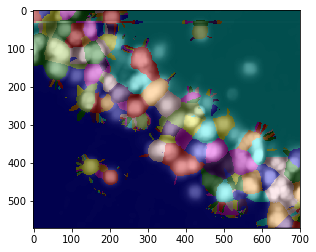

In [84]:
plt.imshow(color.label2rgb(ws_test[1], img_guass_aeq_lmax[9, :, :]));

In [11]:
ws_test.shape

(15, 572, 702)

In [ ]:
from skimage import segmentation
plt.imshow(segmentation.mark_boundaries(img[9, :, :], seg_cells[9, :, :]));

In [ ]:
# seeds = peak_local_max(img_adapteq, min_distance=15, threshold_abs=0.9)

# f, ax = plt.subplots(1,1, figsize=(20,20));
# ax.imshow(img[9, :, :], cmap='gray');
# ax.plot(seeds[:, 1], seeds[:, 0], 'r.');

# median filtering

In [23]:
# # single plane
# median_filter = filters.median(img_gauss[9, :, :], np.ones((7,7)))

/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


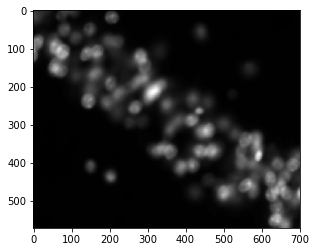

In [24]:
# plt.imshow(median_filter, cmap='gray')

In [50]:

# threshold = threshold_otsu(img_gauss_aeq_lmax)
# bilat = restoration.denoise_bilateral(img_gauss_aeq, win_size=10)
# binary = img_gauss_aeq_lmax > threshold


/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/restoration/_denoise.py:79: UserWarning: denoise_bilateral will default to multichannel=False in v0.15
  warn('denoise_bilateral will default to multichannel=False in v0.15')
/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/restoration/_denoise.py:101: UserWarning: The last axis of the input image is interpreted as channels. Input image with shape (15, 572, 702) has 702 channels in last axis. ``denoise_bilateral`` is implemented for 2D grayscale and color images only
  warn(msg.format(image.shape, image.shape[2]))


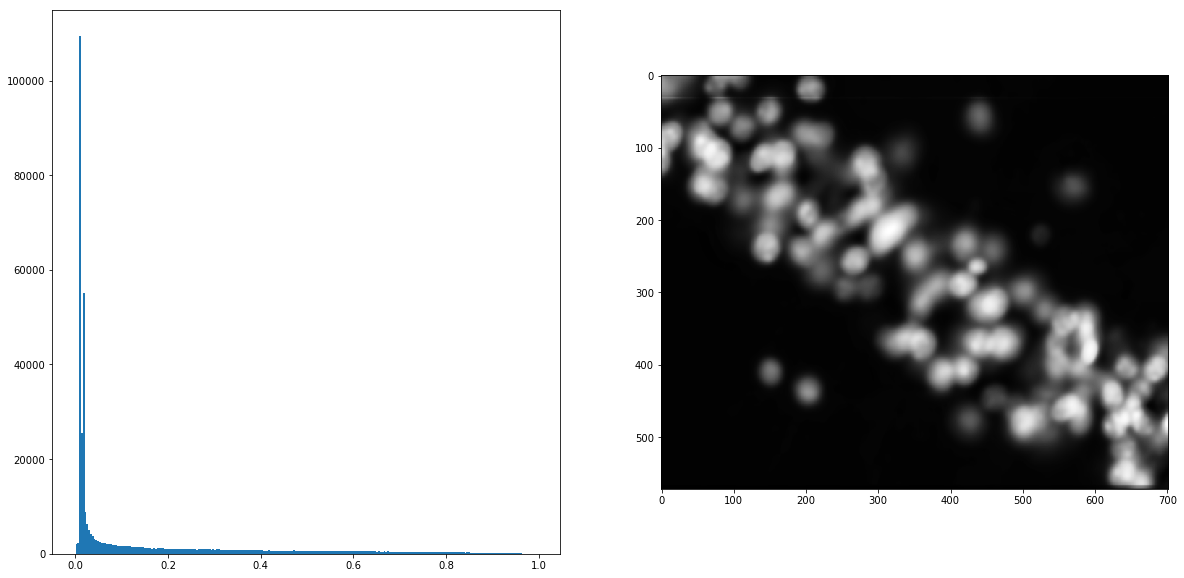

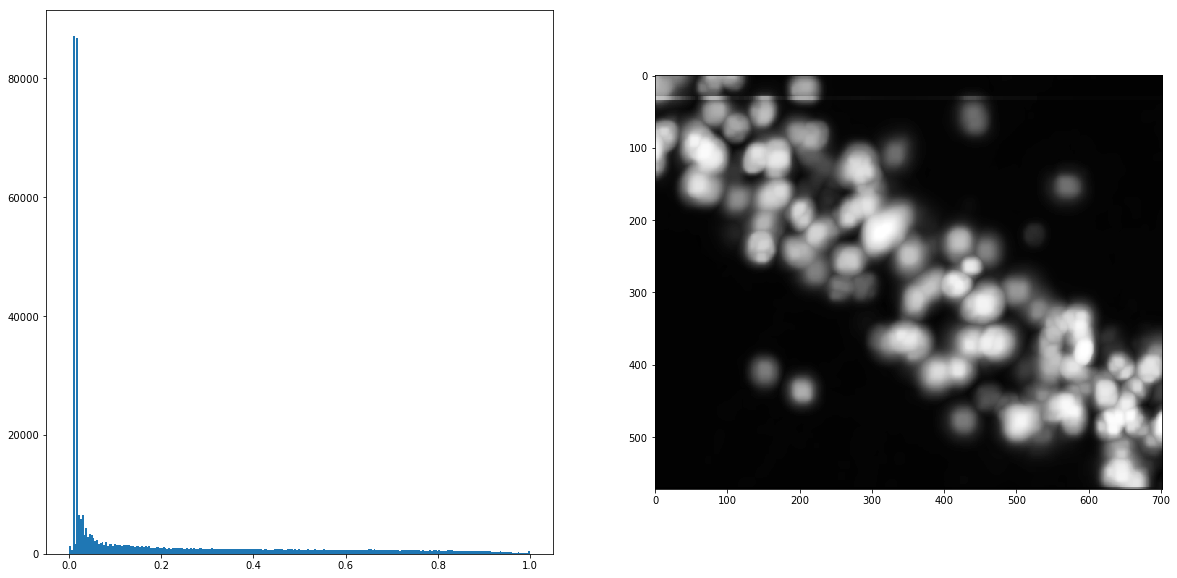

In [51]:
# img_hist_stack(bilat, 9)
# img_hist_stack(img_gauss_aeq_lmax, 9)

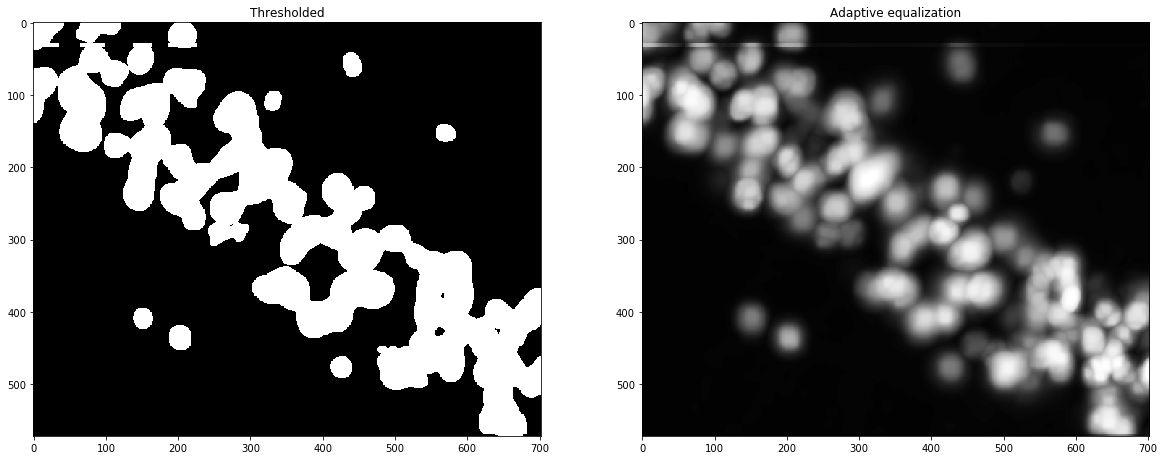

In [65]:
# fig, ax = plt.subplots(ncols=2, figsize=(20,20))
# ax[0].imshow(binary[9, :, :], cmap='gray')
# ax[0].set_title('Thresholded')
# ax[1].imshow(img_gauss_aeq_lmax[9, :, :], cmap='gray')
# ax[1].set_title('Adaptive equalization');

In [57]:
# img_adaptive = threshold_local(img_gauss[9, :, :], 21)